In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, hamming_loss, jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



In [2]:
embeddings = np.load("chest-xray14_embeddings.npy")
annotation = pd.read_csv('Data_Entry_2017.csv')
print(annotation)

             Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_000.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0 

In [3]:

file_path = "selected_png_list.txt"
ids = []

with open(file_path, 'r') as file:
    for line in file:
        full_path = line.strip()  
        filename = os.path.basename(full_path)
        ids.append(filename)

label_dict = annotation.set_index('Image Index')['Finding Labels'].to_dict()

labels = []
for id in ids:
    if label_dict[id] == 'No Finding':
        labels.append(0)
    else:
        labels.append(1)

df = embeddings

mc_df = df - np.mean(df, axis=0)
N, k = mc_df.shape

S = (1/N) * mc_df.transpose() @ mc_df
print(S.shape)

eig_val, eig_vectors = np.linalg.eigh(S)

eig_val_desc = eig_val[::-1]
eig_vectors_desc = eig_vectors[:, ::-1]

U = eig_vectors_desc[:, :343]

X_reduced = mc_df @ U

print(X_reduced.shape)




(512, 512)
(9600, 343)


In [4]:
# Create embeddings train/test split.
# Find the 80% index.
cutoff_inx = int(len(embeddings) * 0.8)

# Split the dataset.
X_train = embeddings[0:cutoff_inx]
X_test = embeddings[cutoff_inx:]
y_test = labels[cutoff_inx:]
y_train = labels[0:cutoff_inx]

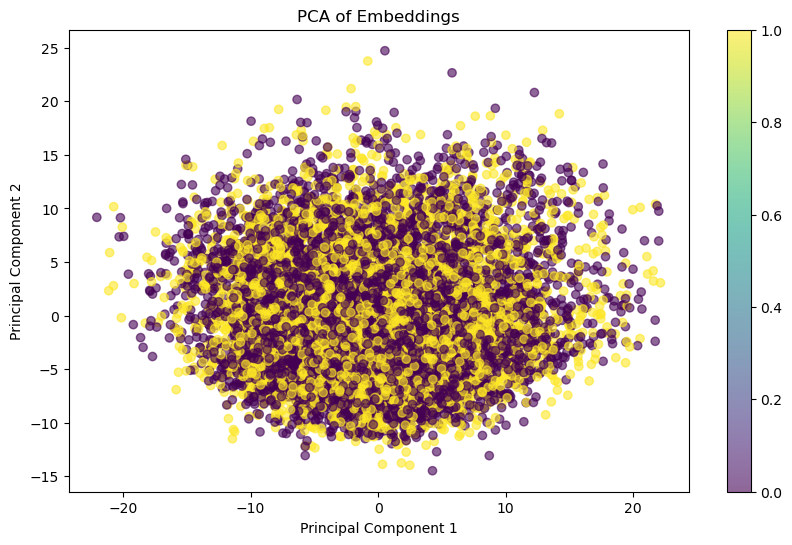

In [5]:

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Initialize PCA, here we are reducing to 2 dimensions for easy visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings_scaled)

# Plotting the results
def plot_pca(principal_components, labels):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.title('PCA of Embeddings')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter)
    plt.savefig('pca.png', dpi = 600)
    plt.show()

plot_pca(principal_components, labels)

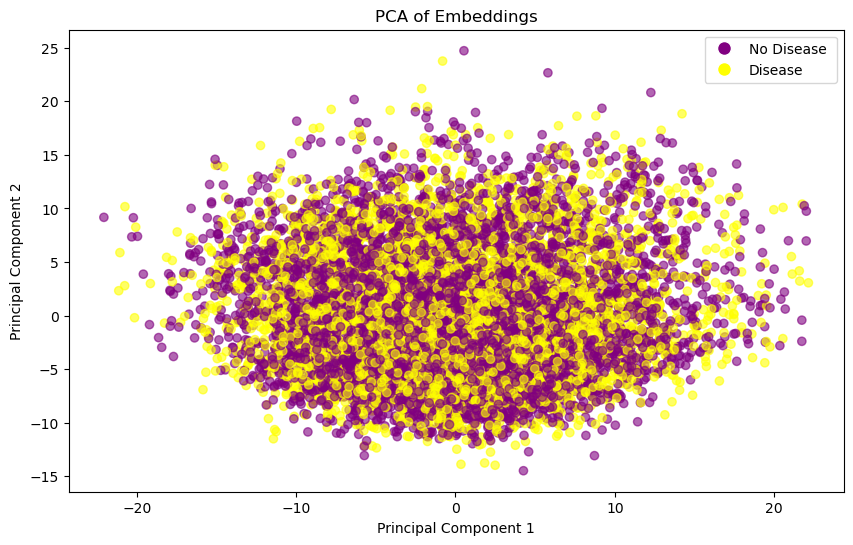

In [23]:
def plot_pca(principal_components, labels):
    plt.figure(figsize=(10, 6))

    # Create a color map for binary labels
    color_map = {0: 'purple', 1: 'yellow'}
    # Map labels to colors using a list comprehension
    scatter_colors = [color_map[label] for label in labels]

    # Scatter plot
    scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1],
                          c=scatter_colors, alpha=0.6)

    # Create a legend manually
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='No Disease ',
                              markerfacecolor='purple', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Disease',
                              markerfacecolor='yellow', markersize=10)]
    plt.legend(handles=legend_elements)

    plt.title('PCA of Embeddings')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.savefig('pca.png', dpi=600)
    plt.show()

plot_pca(principal_components, labels)

## Binary Classification
Instead of one hot encoding each possible outomce and doing a one vs rest logistic classifier, we want to do binary classification if there is a 
disease outcomne or not. This should theoretically improve the accuracy of the model.


# Hand Iplementation

## Logistic Regression
1. Implement Sigmoid function - hard assignment of 0 to 1.
2. Implement a loss function.
3. Implement gradient descent.
4. Prediction function.

In [6]:
# Undersampling
def undersample(X, y):
    # Convert to numpy arrays for easier manipulation
    X = np.array(X)
    y = np.array(y)
    
    # Find the indices of each class
    class0_indices = np.where(y == 0)[0]
    class1_indices = np.where(y == 1)[0]
    
    # Find the number of instances in the smaller class
    n_min = min(len(class0_indices), len(class1_indices))
    
    # Randomly select n_min indices from each class
    np.random.shuffle(class0_indices)
    np.random.shuffle(class1_indices)
    class0_indices = class0_indices[:n_min]
    class1_indices = class1_indices[:n_min]
    
    # Concatenate the indices and extract the samples
    undersampled_indices = np.concatenate((class0_indices, class1_indices))
    X_undersampled = X[undersampled_indices]
    y_undersampled = y[undersampled_indices]
    
    return X_undersampled, y_undersampled



In [7]:
# Implement a sigmoid function.

def sigmoid(x):
    return 1 / (1 + np.exp(-x - 1))


# Compute cross entropy loss
def compute_loss(y, y_hat):
    # Ensure that both y and y_hat are NumPy arrays
    y = np.array(y)
    y_hat = np.array(y_hat)

    # Avoid division by zero and log domain issues
    epsilon = 1e-15
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
    
    # Compute the binary cross-entropy loss
    loss = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    return loss


# Predict function
def predict(X, weights, bias, threshold = 0.5):
    z = np.dot(X, weights) + bias
    y_pred = sigmoid(z)
    print(y_pred)
    return (y_pred >= threshold).astype(int)
    #return y_pred.round()  # returns class labels based on threshold of 0.5


# Implement gradient descent.
def grad_desc(X, y, num_iterations, learning_rate, lambda_param, decay):
    # Perform feature scaling
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0, ddof= 0)

    # Find the shape of X
    X = np.array(X)
    
    m, n = X.shape


    # Set the bias.
    bias = np.random.random()

    # Set weights.
    weights = (np.random.randn(n) * 2 - 1) * 0.05
    #weights = np.zeros(n)

    for i in range(num_iterations):


        # Do the linear combination of the weights plus biases.
        z = np.dot(X, weights) + bias
        # Do the prediction with the current weights.

        predicted = sigmoid(z)
        # Find change in weights. (Calculate the gradient).
        deltaweights = np.dot(X.T, (predicted - y)) / m + lambda_param * (weights) / m
        deltabias = np.sum(predicted - y) / m

        # Update the weights and biases.
        weights -= learning_rate*deltaweights
        bias -= learning_rate*deltabias

        loss = compute_loss(y, predicted)
        # Print out every one hundred steps.
        if num_iterations % 10 == 0.0:
            print(f"Step {i}, Loss: {loss}")
        learning_rate *= decay

    return weights, bias


# Precision, Recall, and F1 Score calculation
def calculate_precision_recall_f1(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)


    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    print(TP, FP, TN, FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    acc = (TP+TN) / (TP+FP+TN+FN)
    return precision, recall, f1_score, acc


def TestWeightsBiases(X_test, y_test, weights, biases):
    # Make predictions
    predictions = predict(X_test, weights, biases)
    # Evaluate precision, recall, and F1 score
    precision, recall, f1_score, acc = calculate_precision_recall_f1(y_test, predictions)

    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_score:.2f}, Accuracy: {acc:.2f}")

def k_fold_cross_validation(X, y, K, num_iterations, learning_rate, lambda_param):
    fold_size = len(X) // K
    accuracies = []
    
    for k in range(K):
        start = k * fold_size
        end = start + fold_size
        X_valid = X[start:end]
        y_valid = y[start:end]
        X_train = np.concatenate([X[:start], X[end:]])
        y_train = np.concatenate([y[:start], y[end:]])

        weights, bias = grad_desc(X_train, y_train, num_iterations, learning_rate, lambda_param)
        y_pred = predict(X_valid, weights, bias)
        accuracy = np.mean(y_pred == y_valid)
        accuracies.append(accuracy)

    return np.mean(accuracies)

In [8]:
# Undersample and balance the classes.
X_train, y_train = undersample(X_train, y_train)

In [9]:
weights, biases = grad_desc(X_train, y_train, 500, 0.125, lambda_param=1e-10, decay = 0.9995)
TestWeightsBiases(X_test, y_test, weights, biases)


Step 0, Loss: 1.3745370294953516
Step 1, Loss: 1.285727041007912
Step 2, Loss: 1.2253426656294937
Step 3, Loss: 1.1803845246742073
Step 4, Loss: 1.145089900665533
Step 5, Loss: 1.116160269322452
Step 6, Loss: 1.091608820349473
Step 7, Loss: 1.070200020536116
Step 8, Loss: 1.051134626497908
Step 9, Loss: 1.0338772616483134
Step 10, Loss: 1.0180594662301254
Step 11, Loss: 1.0034218815564067
Step 12, Loss: 0.9897778990089848
Step 13, Loss: 0.9769900503043534
Step 14, Loss: 0.9649544345124428
Step 15, Loss: 0.9535903796412197
Step 16, Loss: 0.9428335528932931
Step 17, Loss: 0.9326313457988611
Step 18, Loss: 0.9229397571336307
Step 19, Loss: 0.9137212610003532
Step 20, Loss: 0.9049433241717856
Step 21, Loss: 0.8965773538737294
Step 22, Loss: 0.88859793389633
Step 23, Loss: 0.8809822566865602
Step 24, Loss: 0.8737096911357252
Step 25, Loss: 0.8667614463612664
Step 26, Loss: 0.8601203050039687
Step 27, Loss: 0.853770408088059
Step 28, Loss: 0.8476970790316004
Step 29, Loss: 0.841886678033282


In [10]:
model = LogisticRegression(penalty='none')
print(model)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


LogisticRegression(penalty='none')
              precision    recall  f1-score   support

           0       0.58      0.49      0.53      1082
           1       0.45      0.53      0.49       838

    accuracy                           0.51      1920
   macro avg       0.51      0.51      0.51      1920
weighted avg       0.52      0.51      0.51      1920



/Users/tylerkatz/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/tylerkatz/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:

def soft_thresholding(x, lambda_):
    
    if x > lambda_:
        return x - lambda_
    elif x < -lambda_:
        return x + lambda_
    else:
        return 0

def lasso_coordinate_descent(X, y, lambda_, num_iters=100):
    """
    Lasso regression using coordinate descent.

    Parameters:
        X : numpy array, shape (n_samples, n_features)
            Design matrix.
        y : numpy array, shape (n_samples,)
            Response vector.
        lambda_ : float
            Regularization parameter controlling the strength of the L1 penalty.
        num_iters : int
            Number of iterations to run the coordinate descent.

    Returns:
        numpy array, shape (n_features,)
            Coefficients of the Lasso regression.
    """
    
    n_samples, n_features = X.shape

   
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X = (X - X_mean) / X_std

   
    beta = np.zeros(n_features)
    
    
    for _ in range(num_iters):
        for j in range(n_features):
            
            temp_beta = beta.copy()
            
            temp_beta[j] = 0
            
            r = y - X @ temp_beta
            
            rho = np.dot(X[:, j], r)
            
            beta[j] = soft_thresholding(rho / n_samples, lambda_)

    
    beta /= X_std

    return beta


np.random.seed(0)
X = embeddings
y = labels
lambda_ = 0.001


coefficients = lasso_coordinate_descent(X, y, lambda_)
print("Lasso coefficients:", coefficients)


print(np.argmax(coefficients))


Lasso coefficients: [-1.91515091e-01  0.00000000e+00 -1.24607246e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.68805419e-01
  0.00000000e+00 -5.34409700e-01 -1.38630110e+00  1.28913679e+00
  5.12257783e-01 -6.41400284e-01 -4.32624572e-01  3.25910472e-01
 -1.86215872e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.13204148e-01  6.44275448e-01 -1.74549922e-03 -4.48767594e-01
  0.00000000e+00  0.00000000e+00 -6.60371151e-01  0.00000000e+00
 -1.21308290e+00  0.00000000e+00  9.90084164e-02  0.00000000e+00
 -5.67972584e-01  0.00000000e+00  3.09595619e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.02365048e-01  0.00000000e+00
  0.00000000e+00 -7.22361956e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.58338239e-01  0.00000000e+00
 -4.76798876e-01  1.11613853e+00  0.00000000e+00 -1.81702130e-02
 -1.09452315e+00  0.00000000e+00  0.00000000e+00  7.80188514e-01
 -2.16939544e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.0

In [19]:
abs_coefficients = [abs(x) for x in coefficients]
abs_coefficients = np.array(abs_coefficients)
sorted_indices = np.argsort(-abs_coefficients)
#print(sorted_indices[:45])

sorted_beta = coefficients[sorted_indices]
#print(sorted_beta)

count = 0
for coeff in sorted_beta:
    if abs(coeff) > 1:
        count += 1
print(count)


lasso_reduced_indicies = sorted(sorted_indices[:45])
print(len(lasso_reduced_indicies))

print(embeddings.shape)

reduced_embeddings = embeddings[:, lasso_reduced_indicies]

print(reduced_embeddings.shape)

np.save("lasso_reduced_embeddings.npy", reduced_embeddings)


45
45
(9600, 512)
(9600, 45)
